In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import matplotlib.pyplot as plt
from google.colab import drive
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping



In [2]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
data = pd.read_csv("/content/drive/My Drive/dataset/inflation_news_articles.csv", usecols=['title', 'topic'])
data.head()

,title,topic
0,"After 18 months, Wholesale inflation slipped b...",news
1,India's retail inflation eases to 3-month low ...,news
2,Here's Why WPI Inflation Fell to 19-Month Low ...,news
3,WPI inflation eases to 19-month low of 8.39 pc...,news
4,Retail inflation eases sharply to 6.77 per cen...,economics


In [4]:
data.topic.value_counts()

news             6033
finance           555
business          499
economics         302
politics          125
world              81
entertainment      47
energy             40
science            34
sport              24
tech               18
food               14
beauty              6
travel              5
gaming              1
Name: topic, dtype: int64

In [5]:
num_of_categories = 45000
shuffled = data.reindex(np.random.permutation(data.index))
e = shuffled[shuffled['topic'] == 'e'][:num_of_categories]
b = shuffled[shuffled['topic'] == 'b'][:num_of_categories]
t = shuffled[shuffled['topic'] == 't'][:num_of_categories]
m = shuffled[shuffled['topic'] == 'm'][:num_of_categories]
concated = pd.concat([e,b,t,m], ignore_index=True)
#Shuffle the dataset
concated = concated.reindex(np.random.permutation(concated.index))
concated['LABEL'] = 0

In [7]:
#One-hot encode the lab
concated.loc[concated['topic'] == 'e', 'LABEL'] = 0
concated.loc[concated['topic'] == 'b', 'LABEL'] = 1
concated.loc[concated['topic'] == 't', 'LABEL'] = 2
concated.loc[concated['topic'] == 'm', 'LABEL'] = 3
print(concated['LABEL'][:10])
labels = to_categorical(concated['LABEL'], num_classes=4)
print(labels[:10])
if 'CATEGORY' in concated.keys():
    concated.drop(['topic'], axis=1)
'''
 [1. 0. 0. 0.] e
 [0. 1. 0. 0.] b
 [0. 0. 1. 0.] t
 [0. 0. 0. 1.] m
'''

Series([], Name: LABEL, dtype: int64)
[]


'\n [1. 0. 0. 0.] e\n [0. 1. 0. 0.] b\n [0. 0. 1. 0.] t\n [0. 0. 0. 1.] m\n'

In [15]:
n_most_common_words = 8000
max_len = 130
tokenizer = Tokenizer(num_words=n_most_common_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(concated['title'].values)
sequences = tokenizer.texts_to_sequences(concated['title'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = pad_sequences(sequences, maxlen=max_len)

Found 0 unique tokens.


NameError: ignored

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X , labels, test_size=0.25, random_state=42)

NameError: ignored

In [ ]:
epochs = 10
emb_dim = 128
batch_size = 256
labels[:2]

array([[1., 0., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [ ]:
print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))

model = Sequential()
model.add(Embedding(n_most_common_words, emb_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.7))
model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
model.add(Dense(4, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])

((135000, 130), (135000, 4), (45000, 130), (45000, 4))
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 130, 128)          1024000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 130, 128)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 4)                 260       
                                                                 
Total params: 1,073,668
Trainable params: 1,073,668
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
422/422 [==============================] 

In [ ]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

1407/1407 [==============================] - 28s 20ms/step - loss: 0.2210 - acc: 0.9245
Test set
  Loss: 0.221
  Accuracy: 0.925


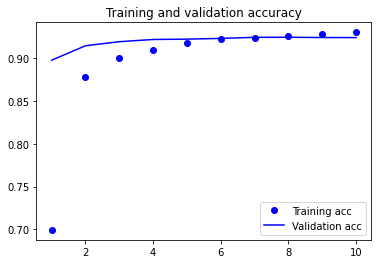

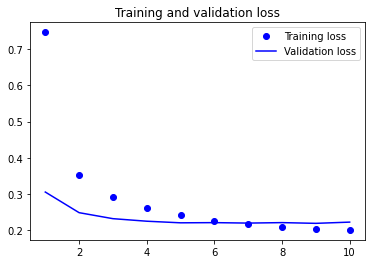

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
txt = ["there are so many stock sales this year"]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)
labels = ['entertainment', 'bussiness', 'science/tech', 'health']
print(pred, labels[np.argmax(pred)])

1/1 [==============================] - 0s 71ms/step
[[0.00359487 0.96103716 0.02166754 0.0137003 ]] bussiness
